In [64]:
# Import Libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt

#Loading Dataset
#dataset = load_dataset('lukebarousse/data_jobs')
#df = dataset['train'].to_pandas()

df = pd.read_csv("C:\\Users\\whitt\\Downloads\\job_postings_flat.csv")

#Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

# filter job_posted_date for 2025
df = df[df['job_posted_date'].dt.year == 2024]

In [65]:
# Only get data analyst jobs in the US
df_DA_US = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'United States')].copy()

In [66]:
# Drop NaN values from the 'salary_year_avg' column for accurate visualization
df_DA_US = df_DA_US.dropna(subset=['salary_year_avg'])

df_DA_US_exploded = df_DA_US.explode('job_skills')

df_DA_US_exploded[['salary_year_avg', 'job_skills']].head(5)

,salary_year_avg,job_skills
787774,100000.0,sql
787774,100000.0,python
787774,100000.0,aws
787774,100000.0,spark
787774,100000.0,kafka


In [67]:
# using df_DA find the count of skills and also the median salary for each skill
df_DA_skills = df_DA_US_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)

df_DA_skills = df_DA_skills.rename(columns={'count': 'skill_count', 'median': 'median_salary'})

DA_job_counts = len(df_DA_US)

df_DA_skills['skill_percent'] = (df_DA_skills['skill_count'] / DA_job_counts) * 100

skill_percent = 5

df_DA_skills_high_demand = df_DA_skills[df_DA_skills['skill_percent'] > skill_percent]

df_DA_skills 

,skill_count,median_salary,skill_percent
job_skills,,,
excel,2597,82500.0,48.217601
sql,2321,97574.0,43.093205
python,1633,100000.0,30.319346
tableau,1249,97500.0,23.189751
power bi,925,93000.0,17.174155
...,...,...,...
redhat,1,100000.0,0.018567
blazor,1,161000.0,0.018567
ruby on rails,1,100000.0,0.018567


In [68]:
skill_limit = 5

df_DA_skills_high_demand = df_DA_skills[df_DA_skills['skill_percent'] > skill_limit]

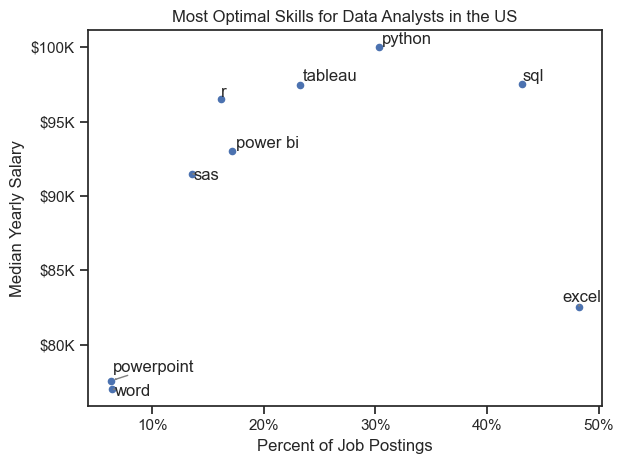

In [69]:
from adjustText import adjust_text
from matplotlib.ticker import PercentFormatter

df_DA_skills_high_demand.plot(kind='scatter', x='skill_percent', y='median_salary')

# Prepare texts for adjustText
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], txt))

# Adjust text to advoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='grey', lw=1))



plt.xlabel('Percent of Job Postings')
plt.ylabel('Median Yearly Salary')
plt.title('Most Optimal Skills for Data Analysts in the US')


ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))


# Adjust layout and display plot
plt.tight_layout()
plt.show() 

In [70]:
df_technology = df['job_type_skills'].copy()

# remove duplicates
df_technology = df_technology.drop_duplicates()

# remove NaN values
df_technology = df_technology.dropna()

# combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)  # convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict:  # if key already exists in technology_dict, add value to existing value
            technology_dict[key] += value
        else:                       # if key does not exist in technology_dict, add key and value
            technology_dict[key] = value

# remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

technology_dict

{'analyst_tools': ['alteryx',
  'sas',
  'power bi',
  'datarobot',
  'dax',
  'ssrs',
  'microstrategy',
  'esquisse',
  'looker',
  'tableau',
  'ms access',
  'spss',
  'cognos',
  'nuix',
  'ssis',
  'sap',
  'spreadsheet',
  'outlook',
  'powerbi',
  'visio',
  'word',
  'splunk',
  'sheets',
  'powerpoint',
  'excel',
  'sharepoint',
  'qlik'],
 'other': ['ansible',
  'docker',
  'unity',
  'puppet',
  'unreal',
  'jenkins',
  'yarn',
  'kubernetes',
  'svn',
  'codecommit',
  'homebrew',
  'atlassian',
  'flow',
  'terminal',
  'pulumi',
  'git',
  'github',
  'gitlab',
  'npm',
  'terraform',
  'chef',
  'bitbucket'],
 'libraries': ['fann',
  'tidyr',
  'dlib',
  'ggplot2',
  'matplotlib',
  'qt',
  'plotly',
  'chainer',
  'pandas',
  'pyspark',
  'seaborn',
  'cordova',
  'numpy',
  'gdpr',
  'capacitor',
  'flutter',
  'tensorflow',
  'gtx',
  'opencv',
  'pytorch',
  'airflow',
  'mxnet',
  'spark',
  'dplyr',
  'hugging face',
  'huggingface',
  'nltk',
  'scikit-learn',
 

In [71]:
# turn dictionary into dataframe
df_technology = pd.DataFrame(list(technology_dict.items()), columns=('technology', 'skills')) 

df_technology = df_technology.explode('skills')

df_technology

,technology,skills
0,analyst_tools,alteryx
0,analyst_tools,sas
0,analyst_tools,power bi
0,analyst_tools,datarobot
0,analyst_tools,dax
...,...,...
9,async,asana
9,async,jira
9,async,smartsheet
9,async,workzone


In [72]:
# merge df_DA_skills and df_technology
df_DA_skills_tech = df_DA_skills.merge(df_technology, left_on='job_skills', right_on='skills')

df_DA_skills_tech 


,skill_count,median_salary,skill_percent,technology,skills
0,2597,82500.0,48.217601,analyst_tools,excel
1,2321,97574.0,43.093205,programming,sql
2,1633,100000.0,30.319346,programming,python
3,1249,97500.0,23.189751,analyst_tools,tableau
4,925,93000.0,17.174155,analyst_tools,power bi
...,...,...,...,...,...
171,1,100000.0,0.018567,os,redhat
172,1,161000.0,0.018567,webframeworks,blazor
173,1,100000.0,0.018567,webframeworks,ruby on rails
174,1,65000.0,0.018567,databases,couchbase


In [73]:
df_DA_skills_tech_high_demand = df_DA_skills_tech[df_DA_skills_tech['skill_percent'] > skill_limit]

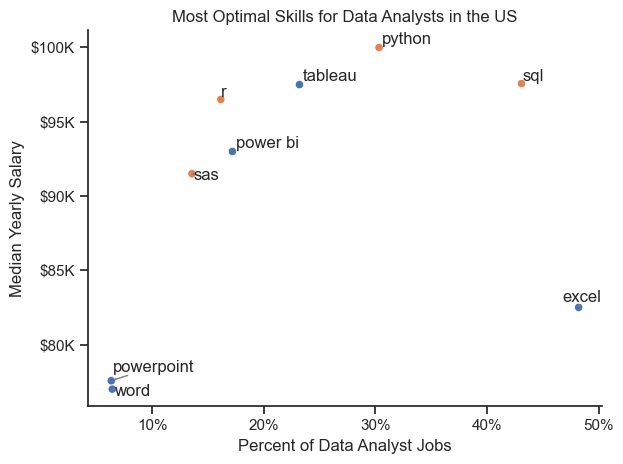

In [87]:
from adjustText import adjust_text

#df_DA_skills_high_demand.plot(kind='scatter', x='skill_percent', y='median_salary')

sns.set_theme(style='ticks')

sns.scatterplot(
    data=df_DA_skills_tech_high_demand,
    x='skill_percent',
    y='median_salary',
    hue='technology'
)

sns.despine()

# Prepare texts for adjustText
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], txt))


# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# Set axis labels, title, and legend
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Yearly Salary')
plt.title('Most Optimal Skills for Data Analysts in the US')


from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))
ax.legend().remove()

# Adjust layout and display plot 
plt.tight_layout()
plt.show()